<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Monitoring Biases in a Recommender System</h1>



**Objective**: We want to monitor the prediction of a recommender system usinf the UpTrain framework. Specifically, we want to check how close the predictions of the model are to the ground truth and also check if the model recommendations suffer from any biases (such as the popularity bias).

**Dataset and ML model**: In this example, we train a recommender system to recommend items to users based on their previous shopping history. The dataset is a subset of the [Coveo data challenge dataset](https://github.com/coveooss/SIGIR-ecom-data-challenge) and the model to train embeddings is the [Word2Vec model](https://en.wikipedia.org/wiki/Word2vec). 


Note: Requires [Gensim](https://pypi.org/project/gensim/) to be installed. We ran the following code successfully with Gensim version 4.3.0.

In [1]:
#!pip install gensim

In [2]:
from scipy.spatial.distance import cosine
import numpy as np
import time

import uptrain
from gensim.models import Word2Vec

from helper_funcs import load_sigir_data, model_predict

/Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's first download the preprocessed SIGIR shopping cart dataset and visualize some of the data-points 

In [3]:
data = load_sigir_data("sigir_data.json")

x_test = data['x_test']
y_test = data['y_test']
inference_batch_size = 10

x_test[42]

Data file exists. Skipping download.


[{'session_id': '8d2cdf570f6ea2b337e33c8649fb5d209e127e45c07cff47ef6ddfe55d3a33ef',
  'event_type': 'event_product',
  'product_action': 'purchase',
  'product_sku': 'd1cd6d3f2ec98bcd365842049f72be5fc839ae8deb18abec6113c5c63202da02',
  'server_timestamp_epoch_ms': '1554203649238',
  'hashed_url': 'e396b36a40f2c41d259a45b80e10cd113eb0bf7540b73f49559e89806f734280'}]

### Step 1: Train the model

Each product has a unique stock-keeping unit (**sku**) that is used as a product identifier. We use [Word2Vec models from Gensim](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to learn a embeddings corresponding to each sku based on shopping sessions of the user.

In [4]:
x_train_sku = [[e['product_sku'] for e in s] for s in data['x_train']]
model = Word2Vec(sentences=x_train_sku, vector_size=48, epochs=15).wv

### Step 2: Monitor model's performance using UpTrain

In [5]:
cfg = {
    "checks": [{
        'type': uptrain.Monitor.CONCEPT_DRIFT,
        'algorithm': uptrain.DataDriftAlgo.DDM,
        "measurable_args": {
            'type': uptrain.MeasurableType.REC_HIT_RATE,
        },
    }], 
    "retraining_folder": 'uptrain_smart_data', 
    "logging_args": {"st_logging": True},
}

cfg

{'checks': [{'type': <Monitor.CONCEPT_DRIFT: 'concept_drift'>,
   'algorithm': <DataDriftAlgo.DDM: 'DDM'>,
   'measurable_args': {'type': <MeasurableType.REC_HIT_RATE: 'hit_rate'>}}],
 'retraining_folder': 'uptrain_smart_data',
 'logging_args': {'st_logging': True}}

In [6]:
framework = uptrain.Framework(cfg)

for i in range(int(len(x_test)/inference_batch_size)):
    # Define input in the format understood by the UpTrain framework
    inputs = {"feats": x_test[i*inference_batch_size:(i+1)*inference_batch_size]}
    
    # Do model prediction
    preds = model_predict(model, inputs['feats'])

    # Log input and output to framework
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Getting ground truth and logging to framework
    y_test_batch = y_test[i*inference_batch_size:(i+1)*inference_batch_size]
    gts = [y[0]['product_sku'] for y in y_test_batch]
    framework.log(identifiers=ids, gts=gts)
    
    # Adding 0.01 sec pause to visualize the results live on the dashboard
    time.sleep(0.01)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8508
  Network URL: http://192.168.6.92:8508

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


As we see from the dashboard, our hit rate is ~10% which isn't much helpful to understand how the model works. Low hit rates are quite common in recommendation systems as the user might be purchasing similar items, but not necessarily the exact item which our model recommended.

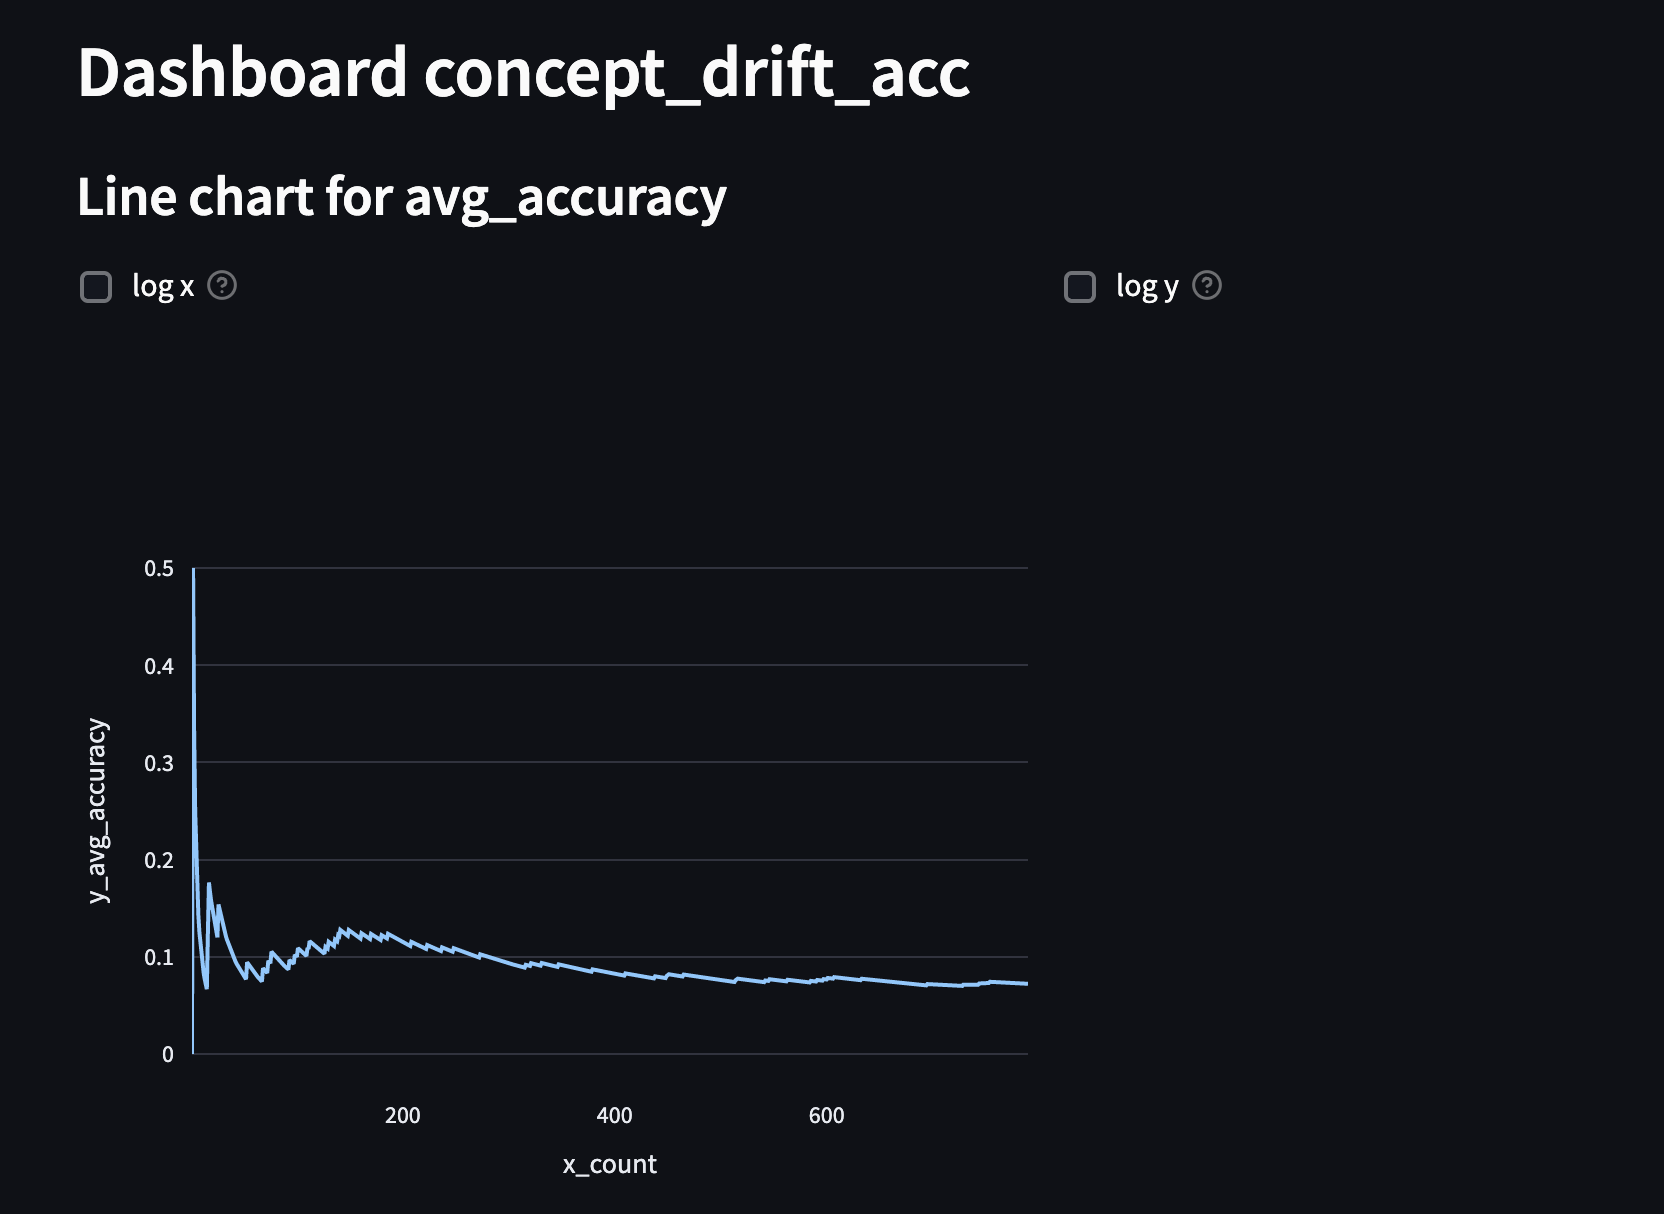

Let's define few custom monitor to get better insights into the performance of our model as well as quantify model biases such as popularity bias.

### Step 3: Define custom monitor (cosine distance between embeddings of predicted and selected items)

Next, we define a custom metric where we want to monitor the cosine distance between embedding vectors of predicted and selected items. Specifically, we want to measure the cosine distance between the ground truth and first predicted item. Low cosine distance means our model is doing a good job in recommending relevant items (even if the hit rate is low)

In [7]:
def cosine_dist_init(self):
    self.cos_distances = []
    self.model = model

def cosine_distance_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt
        try:
            vector_test = self.model.get_vector(y_gt)
        except:
            vector_test = []
        vector_pred = self.model.get_vector(y_preds)
        if len(vector_pred)>0 and len(vector_test)>0:
            cos_dist = cosine(vector_pred, vector_test)
            self.cos_distances.append(cos_dist)
            self.log_handler.add_histogram('cosine_distance', self.cos_distances, self.dashboard_name)

### Step 4: Define another custom monitor (price difference between predicted and selected items)

Next, we also add a custom metric to measure the absolute log ratio between the ground truth and prediction item prices. Values far away from 0 means the recommended items are very different from the ones which the user ended buying. Imagine selling a washing machine to someone who came to purchase washing powder - pretty hard right!

In [8]:
def price_homogeneity_init(self):
    self.price_diff = []
    self.product_data = data['catalog']
    self.price_sel_fn=lambda x: float(x['price_bucket']) if x['price_bucket'] else None
    
def price_homogeneity_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt
        prod_test = self.product_data[y_gt]
        prod_pred = self.product_data[y_preds]
        if self.price_sel_fn(prod_test) and self.price_sel_fn(prod_pred):
            test_item_price = self.price_sel_fn(prod_test)
            pred_item_price = self.price_sel_fn(prod_pred)
            abs_log_price_diff = np.abs(np.log10(pred_item_price/test_item_price))
            self.price_diff.append(abs_log_price_diff)
            self.log_handler.add_histogram('price_homogeneity', self.price_diff, self.dashboard_name)

### Step 5: Define UpTrain config and initialize the framework

In [9]:
cfg = {
    "checks": [
        # Check to monitor the hit-rate of the model 
        # (i.e., if any recommended item was selected)
        {
            'type': uptrain.Monitor.CONCEPT_DRIFT,
            'algorithm': uptrain.DataDriftAlgo.DDM,
            "measurable_args": {
                'type': uptrain.MeasurableType.REC_HIT_RATE,
                },
        },
        # Define a check on popularity bias
        {
            'type': uptrain.Monitor.POPULARITY_BIAS,
            'algorithm': uptrain.BiasAlgo.POPULARITY_BIAS,
            'sessions': x_train_sku,   
        },
        # Custom monitor
        {
            'type': uptrain.Monitor.CUSTOM_MONITOR,
            'initialize_func': cosine_dist_init,
            'check_func': cosine_distance_check,
            'need_gt': True,
            'dashboard_name': 'cosine_distance'
        },
        # Custom monitor
        {
            'type': uptrain.Monitor.CUSTOM_MONITOR,
            'initialize_func': price_homogeneity_init,
            'check_func': price_homogeneity_check,
            'need_gt': True,
            'dashboard_name': 'price_homogeneity'
        }
    ], 
    "retraining_folder": 'uptrain_smart_data', 
    "logging_args": {"st_logging": True},
}

### Step 6: Monitor our model using custom monitors defined in UpTrain

In [10]:
framework = uptrain.Framework(cfg)

for i in range(int(len(x_test)/inference_batch_size)):
    # Define input in the format understood by the UpTrain framework
    inputs = {"feats": x_test[i*inference_batch_size:(i+1)*inference_batch_size]}
    
    # Do model prediction
    preds = model_predict(model, inputs['feats'])

    # Log input and output to framework
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Getting ground truth and logging to framework
    y_test_batch = y_test[i*inference_batch_size:(i+1)*inference_batch_size]
    gts = [y[0]['product_sku'] for y in y_test_batch]
    framework.log(identifiers=ids, gts=gts)
    
    # Adding 1 sec pause to visualize the results live on the dashboard
    time.sleep(0.01)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs


### Histogram plot for items with popularity

From the UpTrain dashboard, we can find the histogram for popularity bias. We can see that most of the items that are recommended have low popularity. Our model does not look to be suffering from popularity bias.

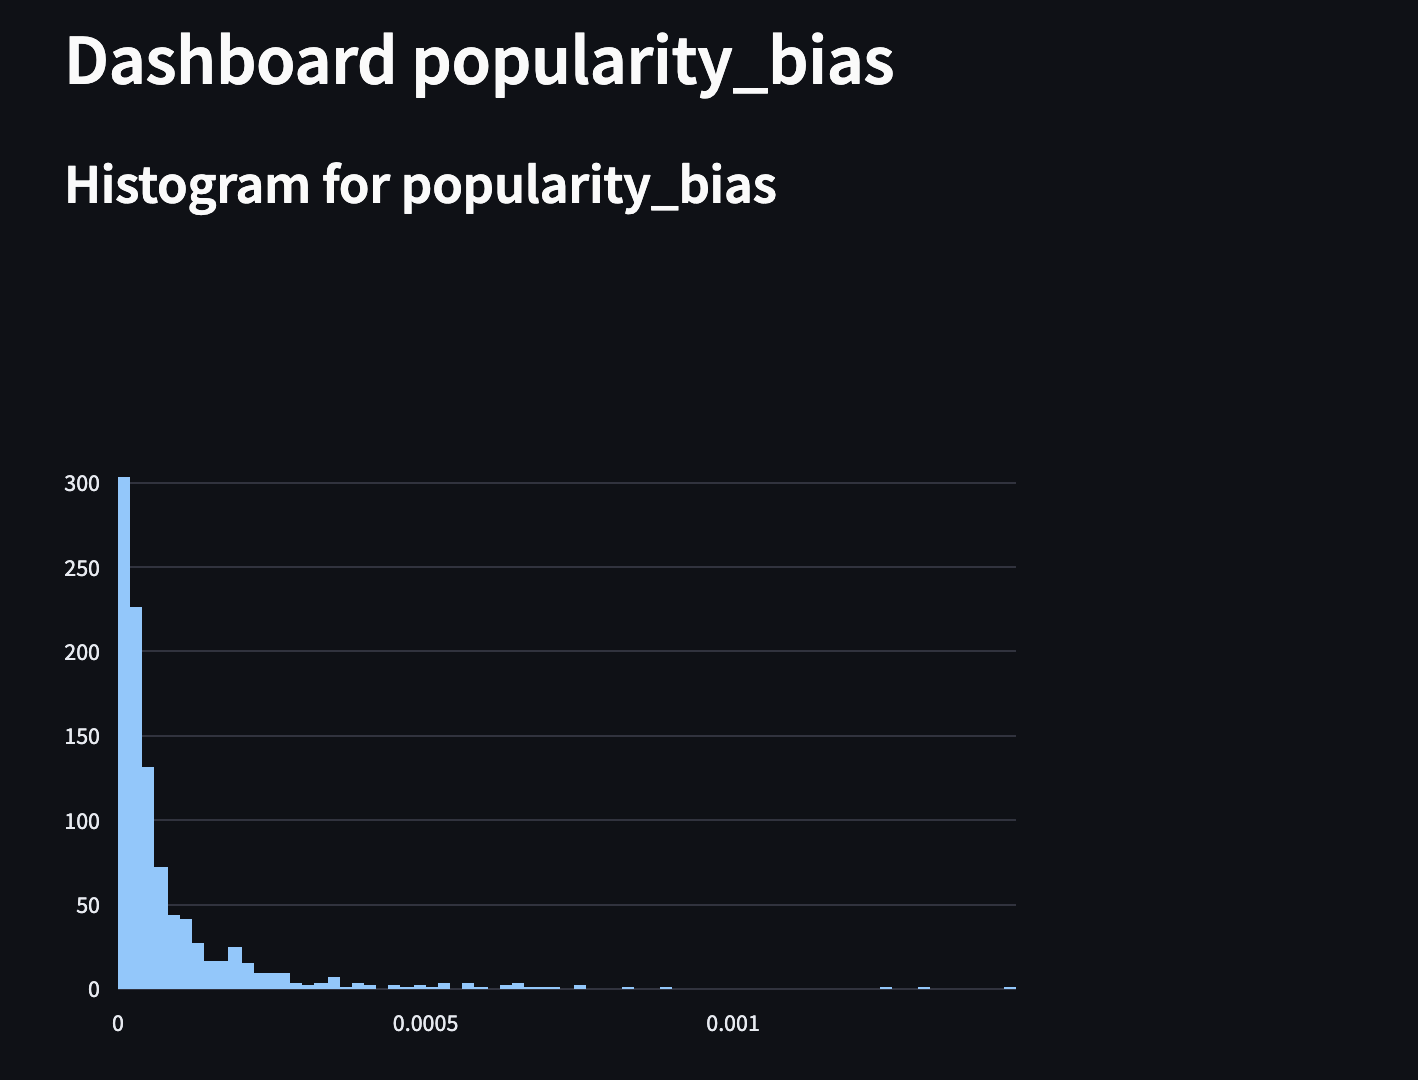

### Histogram plot for cosine distance between ground truth and prediction

In the dashboard, we can measure the cosine distance between the embeddings of the recommended items and the items that were actually bought. A lot of them have zero cosine distance (implying that the recommendations were spot on). Also, we observe that the predictions are concentrated around the low cosine distance (< 0.4) space.

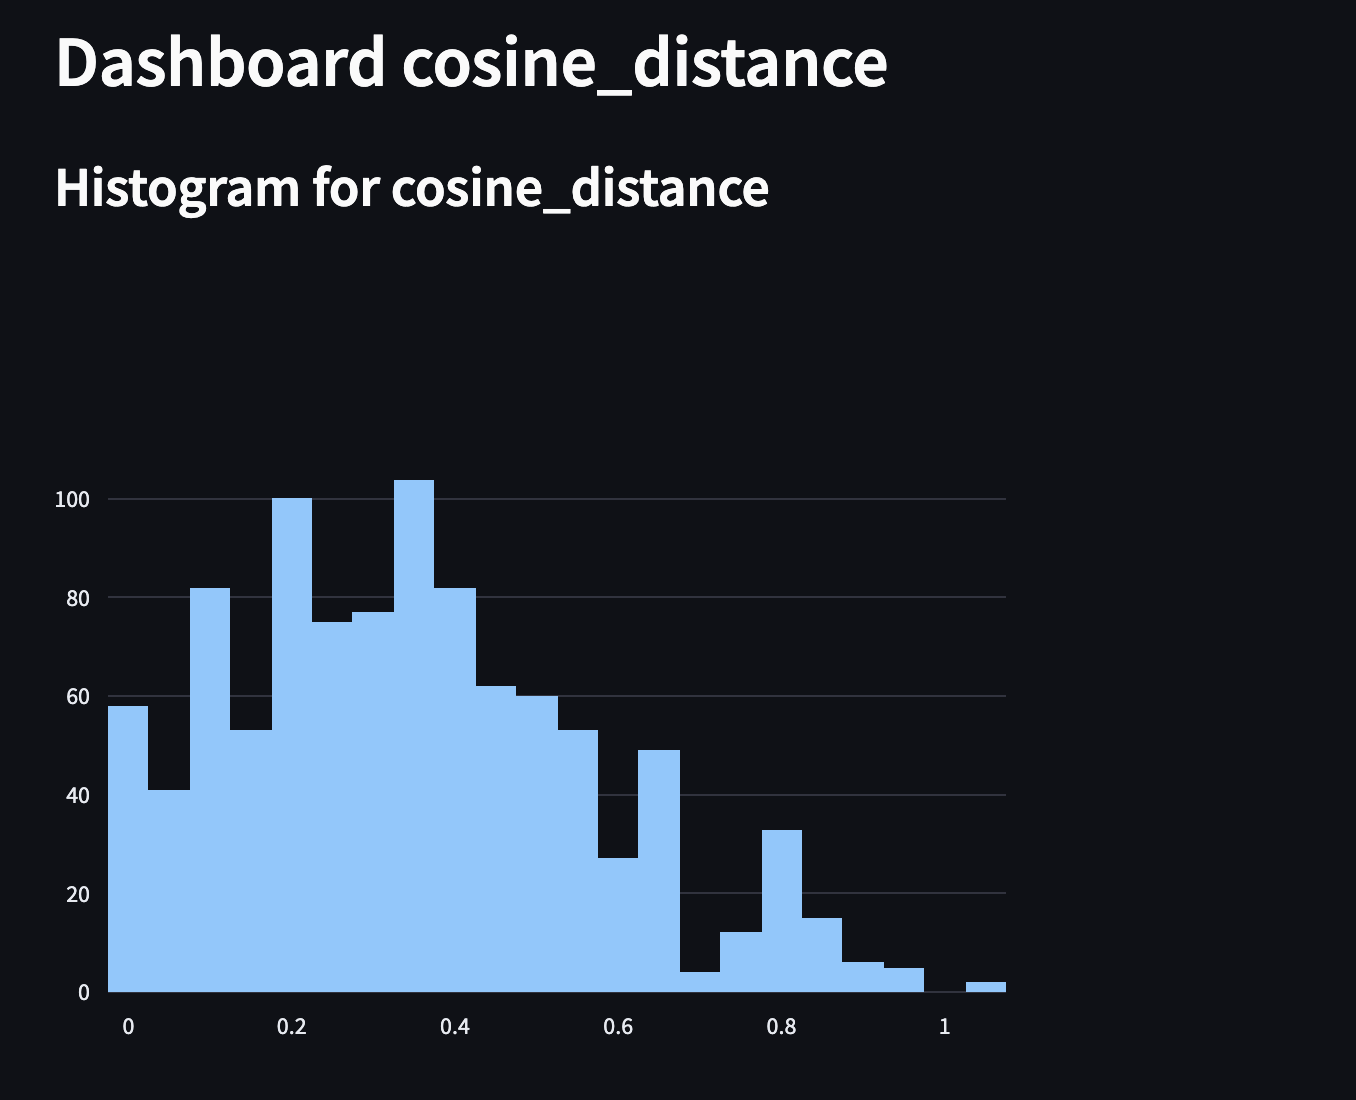

### Histogram plot for absolute log price ratio between prediction and selected items

Finally, we also added a custom monitor where we wanted to check whether our model is providing outrageous recommendations (e.g., recommending washing machines when the user wants to buy just a washing detergent). In the below plot, we observe that the price range of most of the recommended items is close to the price of the actually bought item.

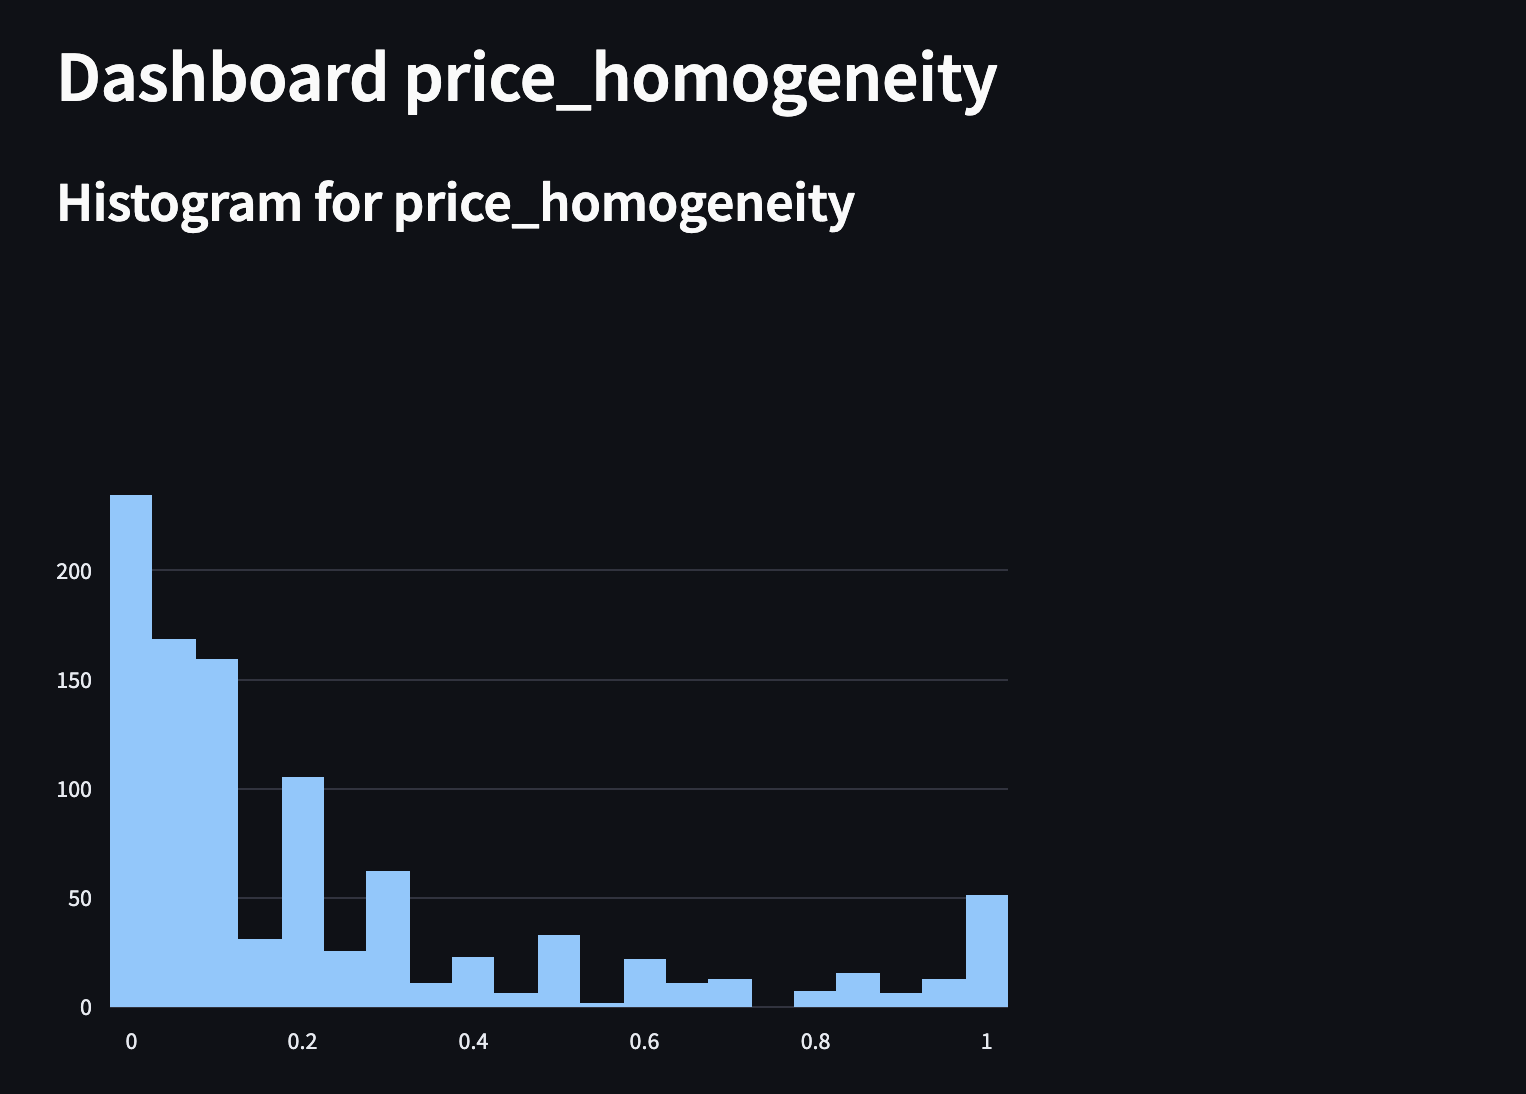